In [1]:
import torch
from time import perf_counter
import numpy as np
from torch import nn
from torch.nn import Sequential
from common.conv2d_img2col import Conv2dImg2Col
from torch.profiler import profile, record_function, ProfilerActivity, schedule
import copy
import os
import cv2

import albumentations as A
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

os.chdir("/workspaces/conv2d_reimagined")

from experiments.conv2d_img2col_QAT import create_dummy_dataloader
from torch.quantization.quantize_fx import convert_fx
from torch.ao.quantization import get_default_qat_qconfig_mapping
from src.models.dummy import DummyModel
from src.core.latency import (
    latency_cpu,
    latency_gpu,
    latency_cpu_profiler,
    latency_gpu_event,
)
from src.core.quant import setup_qat_for_model

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device(type='cuda', index=0)

In [4]:
def get_dummy_model_input(batch=4, replace_conv2d=False):
    model = DummyModel(replaced_conv=replace_conv2d)
    input = torch.randn(batch, 3, 64, 64, requires_grad=False)

    model.to(device)
    input = input.to(device)

    model.eval()
    lcpu = latency_cpu(model, input, warmup_n=10, benchmark_n=30)
    lgpu = latency_gpu(model, input, warmup_n=10, benchmark_n=30)
    lcpu_p1 = latency_cpu_profiler(model, input, warmup_n=10, benchmark_n=30)
    print(lcpu_p1.key_averages().table(sort_by="self_cpu_time_total", row_limit=5))
    return model, input

## Simple Sequential

In [19]:
model = nn.Sequential(
    Conv2dImg2Col(3, 16, kernel_size=3, stride=1, padding=1, bias=True)
)

input = torch.randn(2, 3, 320, 320, requires_grad=True)

model.to(device)
input = input.to(device)

In [4]:
latency_gpu(model, input, warmup_n=10, benchmark_n=10)
latency_gpu_event(model, input, warmup=10, repeat=10)

Start GPU benchmark with input shape: torch.Size([2, 3, 320, 320]) cuda:0
0.774ms +- 0.791ms


(0.4345855712890625, 0.053540829569101334)

In [5]:
latency_cpu(model, input, warmup_n=10, benchmark_n=30)

Start CPU benchmark with input shape: torch.Size([2, 3, 320, 320]) cpu
13.079ms +- 2.903ms


(13.078514499648008, 2.9029896674571525)

In [22]:
model.to("cpu")
input = input.to("cpu")
print(input.device)
prof = latency_cpu_profiler(model, input, warmup_n=10, benchmark_n=30)
print(
    prof.key_averages(group_by_input_shape=True).table(
        sort_by="cpu_time_total", row_limit=15
    )
)

cpu
-------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  --------------------------------------------------------  
                     Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls                                              Input Shapes  
-------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  --------------------------------------------------------  
          model_inference         7.20%       2.826ms       100.00%      39.260ms      39.260ms           0 b     -35.97 Mb             1                                                        []  
         aten::contiguous         0.02%       9.000us        64.74%      25.416ms      25.416ms      21.09 Mb           0 b             1                              [[2, 320, 320, 3, 3, 3], []]  
      

STAGE:2025-10-24 15:07:02 9096:9096 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-10-24 15:07:03 9096:9096 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-10-24 15:07:03 9096:9096 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


## Simple Model

In [3]:
model, input = get_dummy_model_input(16)
print("\n--- post training dynamic/weight_only quantization ---")

# config = get_default_qat_qconfig_mapping("x86") # qnnpack
prepared_model = copy.deepcopy(model)
prepared_model = setup_qat_for_model(prepared_model, input, config=None)
prepared_model.eval()
print()

Start CPU benchmark with input shape: torch.Size([16, 3, 64, 64]) cpu
53.059ms +- 3.258ms
Start GPU benchmark with input shape: torch.Size([16, 3, 64, 64]) cuda:0
1.209ms +- 0.379ms


/usr/local/lib/python3.10/dist-packages/torch/profiler/profiler.py:510: UserWarning: use_cuda is deprecated, use activities argument instead
  warn("use_cuda is deprecated, use activities argument instead")


--------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                            Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
--------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
        aten::mkldnn_convolution        67.71%      37.652ms        68.03%      37.830ms      12.610ms      28.00 Mb           0 b             3  
                 aten::clamp_min        14.94%       8.309ms        14.94%       8.309ms       2.770ms      28.00 Mb      28.00 Mb             3  
                 model_inference         5.02%       2.789ms       100.00%      55.607ms      55.607ms           0 b     -84.00 Mb             1  
         aten::native_batch_norm         3.91%       2.172ms         4.00%       2.227ms     742.333us      28.00 Mb  

STAGE:2025-10-24 15:46:58 22356:22356 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-10-24 15:46:58 22356:22356 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-10-24 15:46:58 22356:22356 ActivityProfilerController.cpp:322] Completed Stage: Post Processing
/usr/local/lib/python3.10/dist-packages/torch/ao/quantization/observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


In [4]:
lcpu = latency_cpu(prepared_model, input, warmup_n=10, benchmark_n=30)
lcpu_p1 = latency_cpu_profiler(prepared_model, input, warmup_n=10, benchmark_n=30)

prepared_model.cpu()
save = convert_fx(prepared_model)
print("\n--- after  convert_fx ---")
lcpu = latency_cpu(save, input, warmup_n=10, benchmark_n=30)
lcpu_p2 = latency_cpu_profiler(save, input, warmup_n=10, benchmark_n=30)

Start CPU benchmark with input shape: torch.Size([16, 3, 64, 64]) cpu
60.233ms +- 11.772ms

--- after  convert_fx ---


/usr/local/lib/python3.10/dist-packages/torch/profiler/profiler.py:510: UserWarning: use_cuda is deprecated, use activities argument instead
  warn("use_cuda is deprecated, use activities argument instead")
STAGE:2025-10-24 15:47:03 22356:22356 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-10-24 15:47:03 22356:22356 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-10-24 15:47:03 22356:22356 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


Start CPU benchmark with input shape: torch.Size([16, 3, 64, 64]) cpu
18.577ms +- 2.144ms


STAGE:2025-10-24 15:47:04 22356:22356 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-10-24 15:47:04 22356:22356 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-10-24 15:47:04 22356:22356 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


In [5]:
print(
    lcpu_p1.key_averages(group_by_input_shape=True).table(
        sort_by="cpu_time_total", row_limit=5
    )
)

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  --------------------------------------------------------------------------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls                                                                      Input Shapes  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  --------------------------------------------------------------------------------  
                                        model_inference        18.10%      12.006ms       100.00%      66.340ms      66.340ms           0 b     -91.77 Mb             1                                                                             

In [6]:
print(
    lcpu_p2.key_averages(group_by_input_shape=True).table(
        sort_by="cpu_time_total", row_limit=5
    )
)

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------------------------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls                          Input Shapes  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------------------------------  
                  model_inference         8.10%       1.749ms       100.00%      21.591ms      21.591ms           0 b      -7.19 Mb             1                                    []  
           quantized::conv2d_relu        49.47%      10.681ms        49.59%      10.706ms      10.706ms       4.00 Mb     -16.00 Mb             1        [[16, 32, 64, 64], [], [], []]  
           quantized::conv2d_relu        26.46%       5.712ms        2

#### Simple Model with replaced conv

In [5]:
model, input = get_dummy_model_input(16, replace_conv2d=True)
print("\n--- post training dynamic/weight_only quantization ---")

# config = get_default_qat_qconfig_mapping("x86") # qnnpack
prepared_model = copy.deepcopy(model)
prepared_model = setup_qat_for_model(prepared_model, input, config=None)
prepared_model.eval()
print()

Start CPU benchmark with input shape: torch.Size([16, 3, 64, 64]) cpu
101.033ms +- 16.026ms
Start GPU benchmark with input shape: torch.Size([16, 3, 64, 64]) cuda:0
2.602ms +- 0.774ms


/usr/local/lib/python3.10/dist-packages/torch/profiler/profiler.py:510: UserWarning: use_cuda is deprecated, use activities argument instead
  warn("use_cuda is deprecated, use activities argument instead")
STAGE:2025-10-24 15:53:01 23946:23946 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-10-24 15:53:02 23946:23946 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-10-24 15:53:02 23946:23946 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


--------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                            Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
--------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                     aten::copy_        47.92%      81.330ms        47.92%      81.330ms      10.166ms           0 b           0 b             8  
                        aten::mm        21.05%      35.730ms        21.05%      35.730ms      11.910ms      28.00 Mb      28.00 Mb             3  
                 model_inference        11.04%      18.738ms       100.00%     169.729ms     169.729ms           0 b    -212.31 Mb             1  
         aten::native_batch_norm         8.19%      13.896ms         8.27%      14.037ms       4.679ms      28.00 Mb  

/usr/local/lib/python3.10/dist-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/usr/local/lib/python3.10/dist-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
/usr/local/lib/python3.10/dist-packages/torch/overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
/usr/local/lib/python3.10/dist-packages/torch/overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,


/usr/local/lib/python3.10/dist-packages/torch/ao/quantization/observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


In [6]:
lcpu = latency_cpu(prepared_model, input, warmup_n=10, benchmark_n=30)
lcpu_p1 = latency_cpu_profiler(prepared_model, input, warmup_n=10, benchmark_n=30)

prepared_model.cpu()
save = convert_fx(prepared_model)
print("\n--- after  convert_fx ---")
lcpu = latency_cpu(save, input, warmup_n=10, benchmark_n=30)
lcpu_p2 = latency_cpu_profiler(save, input, warmup_n=10, benchmark_n=30)

Start CPU benchmark with input shape: torch.Size([16, 3, 64, 64]) cpu
857.720ms +- 68.400ms


/usr/local/lib/python3.10/dist-packages/torch/profiler/profiler.py:510: UserWarning: use_cuda is deprecated, use activities argument instead
  warn("use_cuda is deprecated, use activities argument instead")
STAGE:2025-10-24 15:53:52 23946:23946 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-10-24 15:53:53 23946:23946 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-10-24 15:53:53 23946:23946 ActivityProfilerController.cpp:322] Completed Stage: Post Processing



--- after  convert_fx ---
Start CPU benchmark with input shape: torch.Size([16, 3, 64, 64]) cpu
103.598ms +- 12.411ms


STAGE:2025-10-24 15:53:58 23946:23946 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-10-24 15:53:58 23946:23946 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-10-24 15:53:58 23946:23946 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


In [7]:
print(
    lcpu_p2.key_averages(group_by_input_shape=True).table(
        sort_by="cpu_time_total", row_limit=5
    )
)

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ----------------------------------------------------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls                                                Input Shapes  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ----------------------------------------------------------  
                  model_inference         1.83%       2.051ms       100.00%     111.845ms     111.845ms           0 b    -241.49 Mb             1                                                          []  
        aten::quantize_per_tensor         3.43%       3.832ms        26.74%      29.904ms      29.904ms      18.00 Mb     -54.00 Mb             1                       

##### Calibrated for static quant

In [7]:
model, input = get_dummy_model_input(16)
print("\n--- post training dynamic/weight_only quantization ---")

# config = get_default_qat_qconfig_mapping("x86") # qnnpack
prepared_model = copy.deepcopy(model)
prepared_model = setup_qat_for_model(prepared_model, input, config=None)
loader = create_dummy_dataloader()

prepared_model = prepared_model.to(device)
prepared_model.eval()
with torch.no_grad():
    for data, target in loader:  # dataloader transfer data to device
        prepared_model(data)

prepared_model.eval()
prepared_model.cpu()
save = convert_fx(prepared_model)
print("\n--- after  convert_fx ---")
lcpu = latency_cpu(save, input, warmup_n=10, benchmark_n=30)
lcpu_p2 = latency_cpu_profiler(save, input, warmup_n=10, benchmark_n=30)

Start CPU benchmark with input shape: torch.Size([16, 3, 64, 64]) cpu
43.836ms +- 8.974ms
Start GPU benchmark with input shape: torch.Size([16, 3, 64, 64]) cuda:0
1.574ms +- 0.554ms
--------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                            Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
--------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
        aten::mkldnn_convolution        68.80%      26.064ms        69.09%      26.174ms       8.725ms      28.00 Mb           0 b             3  
                 aten::clamp_min        13.59%       5.148ms        13.59%       5.148ms       1.716ms      28.00 Mb      28.00 Mb             3  
         aten::native_batch_norm         8.49%       3.215ms         8.58%       3.

STAGE:2025-10-24 15:47:17 22356:22356 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-10-24 15:47:17 22356:22356 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-10-24 15:47:17 22356:22356 ActivityProfilerController.cpp:322] Completed Stage: Post Processing
/usr/local/lib/python3.10/dist-packages/torch/ao/quantization/fake_quantize.py:343: UserWarning: _aminmax is deprecated as of PyTorch 1.11 and will be removed in a future release. Use aminmax instead. This warning will only appear once per process. (Triggered internally at ../aten/src/ATen/native/ReduceAllOps.cpp:72.)
  return torch.fused_moving_avg_obs_fake_quant(



--- after  convert_fx ---
Start CPU benchmark with input shape: torch.Size([16, 3, 64, 64]) cpu
18.673ms +- 2.247ms


STAGE:2025-10-24 15:47:18 22356:22356 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-10-24 15:47:18 22356:22356 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-10-24 15:47:18 22356:22356 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


In [8]:
print(
    lcpu_p2.key_averages(group_by_input_shape=True).table(
        sort_by="cpu_time_total", row_limit=5
    )
)

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------------------------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls                          Input Shapes  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------------------------------  
                  model_inference         4.72%     867.000us       100.00%      18.361ms      18.361ms           0 b      -7.19 Mb             1                                    []  
           quantized::conv2d_relu        54.57%      10.019ms        54.62%      10.029ms      10.029ms       4.00 Mb     -16.00 Mb             1        [[16, 32, 64, 64], [], [], []]  
           quantized::conv2d_relu        22.96%       4.216ms        2

##### Export tests

In [21]:
print("start export  via tracing with shape: input =", input.shape)
save_traced = torch.jit.trace(save, input.cpu())

start export  via tracing with shape: input = torch.Size([16, 3, 64, 64])


In [22]:
lcpu_traced = latency_cpu_profiler(save_traced, input, warmup_n=10, benchmark_n=30)
print(
    lcpu_traced.key_averages(group_by_input_shape=True).table(
        sort_by="cpu_time_total", row_limit=5
    )
)

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------------------------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls                          Input Shapes  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------------------------------  
                  model_inference        27.22%      21.425ms       100.00%      78.712ms      78.712ms           0 b        -640 b             1                                    []  
                          forward         0.43%     335.000us        72.78%      57.287ms      57.287ms         640 b           0 b             1                 [[], [16, 3, 64, 64]]  
           quantized::conv2d_relu        37.29%      29.352ms        3

/usr/local/lib/python3.10/dist-packages/torch/profiler/profiler.py:510: UserWarning: use_cuda is deprecated, use activities argument instead
  warn("use_cuda is deprecated, use activities argument instead")
STAGE:2025-10-24 15:19:22 12775:12775 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-10-24 15:19:22 12775:12775 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-10-24 15:19:22 12775:12775 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


In [25]:
save_scripted = torch.jit.script(save)
lcpu_save_scripted = latency_cpu_profiler(
    save_scripted, input, warmup_n=10, benchmark_n=30
)
print(
    lcpu_save_scripted.key_averages(group_by_input_shape=True).table(
        sort_by="cpu_time_total", row_limit=5
    )
)

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------------------------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls                          Input Shapes  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------------------------------  
                  model_inference        16.26%       7.230ms       100.00%      44.458ms      44.458ms           0 b        -640 b             1                                    []  
                          forward         1.99%     883.000us        83.74%      37.228ms      37.228ms         640 b        -160 b             1                 [[], [16, 3, 64, 64]]  
           quantized::conv2d_relu        44.57%      19.814ms        4

/usr/local/lib/python3.10/dist-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/profiler/profiler.py:510: UserWarning: use_cuda is deprecated, use activities argument instead
  warn("use_cuda is deprecated, use activities argument instead")
STAGE:2025-10-24 15:21:00 12775:12775 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-10-24 15:21:00 12775:12775 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-10-24 15:21:00 12775:12775 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


In [ ]:
export_onnx(save, example_input, "traced")
torch.jit.save(save, "model-jit-trace.pt")
torch.cuda.empty_cache()
print("Model quantization complete!")
print("Models saved!")

# CamVidModel

In [2]:
from src.models.camvid_segmentation_multiclass import (
    get_dataloaders,
    CamVidModel,
    visualize_sample,
    visualize_data,
    train_val,
    save_load_torch_model,
)

DATA_DIR = "/workspaces/conv2d_reimagined/data/CamVid"

x_train_dir = os.path.join(DATA_DIR, "train")
y_train_dir = os.path.join(DATA_DIR, "trainannot")

x_valid_dir = os.path.join(DATA_DIR, "val")
y_valid_dir = os.path.join(DATA_DIR, "valannot")

x_test_dir = os.path.join(DATA_DIR, "test")
y_test_dir = os.path.join(DATA_DIR, "testannot")

train_loader, valid_loader, test_loader = get_dataloaders(
    x_train_dir,
    y_train_dir,
    x_valid_dir,
    y_valid_dir,
    x_test_dir,
    y_test_dir,
    bs = 4
)

# Some training hyperparameters

EPOCHS = 50
T_MAX = EPOCHS * len(train_loader)
# Always include the background as a class
OUT_CLASSES = len(train_loader.dataset.CLASSES)

/usr/local/lib/python3.10/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/workspaces/conv2d_reimagined/src/models/camvid_segmentation_multiclass.py:264: UserWarning: Argument(s) 'always_apply' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=320, min_width=320, always_apply=True),
/workspaces/conv2d_reimagined/src/models/camvid_segmentation_multiclass.py:265: UserWarning: Argument(s) 'always_apply' are not valid for transform RandomCrop
  A.RandomCrop(height=320, width=320, always_apply=True),


Mask shape: (360, 480)


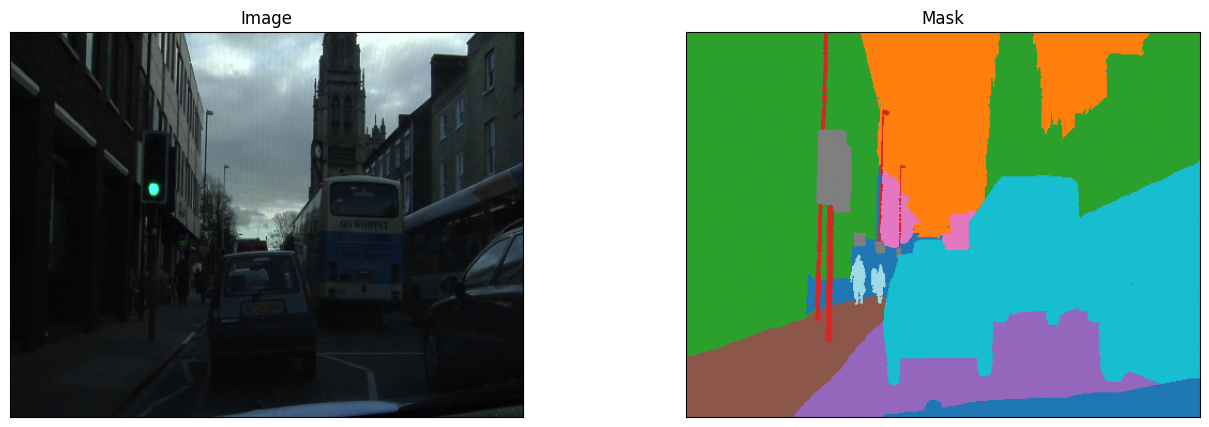

Mask shape: (320, 320)
[ 0  1  2  3  4  5  6  7  9 10]


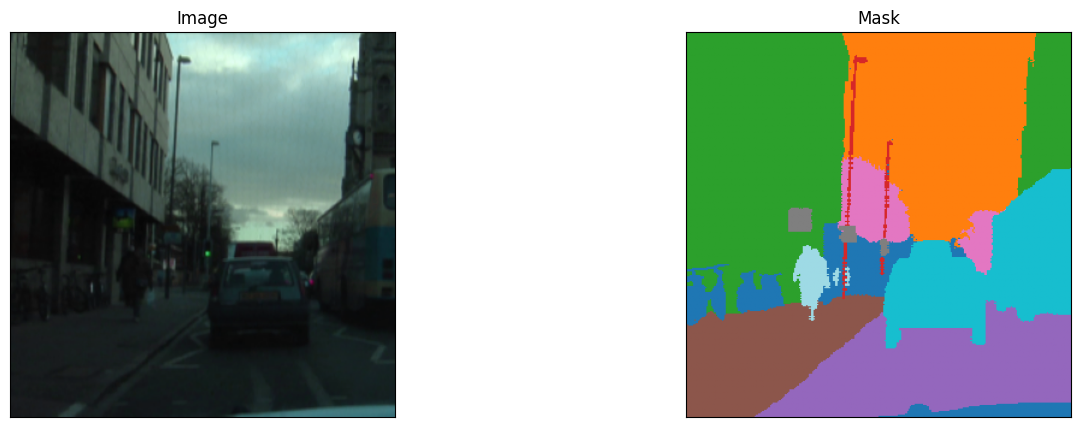

Mask shape: (320, 320)
[ 0  1  2  3  4  5  6  7  9 10]


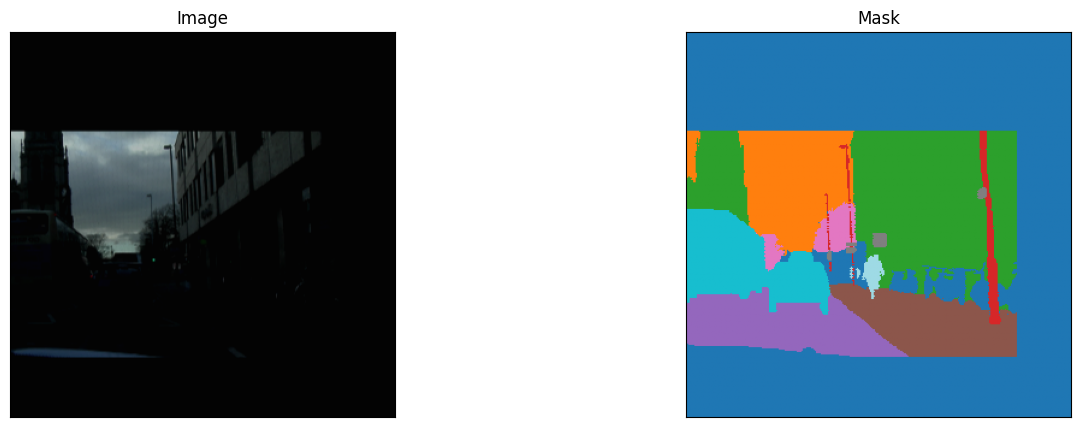

Mask shape: (320, 320)
[ 0  1  2  3  4  5  6  7  9 10]


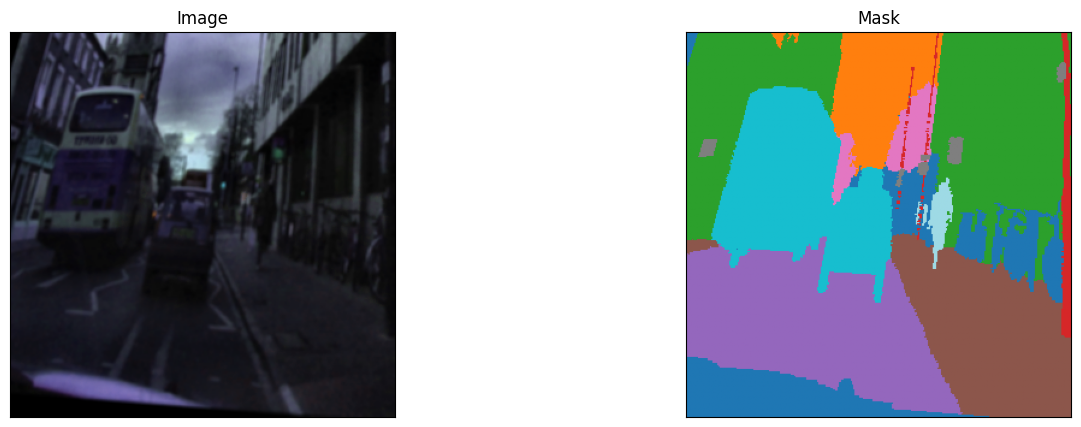

In [4]:
visualize_data(x_train_dir, y_train_dir)

In [5]:
model = CamVidModel("FPN", "resnext50_32x4d", in_channels=3, out_classes=OUT_CLASSES)
train_val(model, train_loader, valid_loader, test_loader, max_epochs=1)

save_load_torch_model(model, path = 'camvid')
model_loaded = save_load_torch_model(model, save=False)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 12/12 [00:55<00:00,  0.21it/s, v_num=1, valid_per_image_iou=0.550, valid_dataset_iou=0.550]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [01:05<00:00,  0.18it/s, v_num=1, valid_per_image_iou=0.550, valid_dataset_iou=0.550]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 4/4 [00:07<00:00,  0.51it/s]
[{'valid_per_image_iou': 0.5499696135520935, 'valid_dataset_iou': 0.5496429800987244}]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 8/8 [00:26<00:00,  0.30it/s]
[{'test_per_image_iou': 0.5129106640815735, 'test_dataset_iou': 0.5105372071266174}]


([{'valid_per_image_iou': 0.5499696135520935,
   'valid_dataset_iou': 0.5496429800987244}],
 [{'test_per_image_iou': 0.5129106640815735,
   'test_dataset_iou': 0.5105372071266174}])

In [4]:
model = CamVidModel("FPN", "resnext50_32x4d", in_channels=3, out_classes=OUT_CLASSES)
# model_loaded = torch.nn.Sequential(*(list(model_loaded.children())[:-1]))
input, gt = next(iter(valid_loader))

In [5]:
lgpu = latency_gpu(model, input, warmup_n=2, benchmark_n=2)

Start GPU benchmark with input shape: torch.Size([32, 3, 384, 480]) cuda:0
33967.973ms +- 321.542ms


In [5]:

lcpu = latency_cpu(model, input, warmup_n=2, benchmark_n=5)
lgpu = latency_gpu(model, input, warmup_n=2, benchmark_n=5)
lcpu_p1 = latency_cpu_profiler(model, input, warmup_n=2, benchmark_n=5)
print(lcpu_p1.key_averages().table(sort_by="self_cpu_time_total", row_limit=5))

print()

Start CPU benchmark with input shape: torch.Size([4, 3, 384, 480]) cpu
2625.407ms +- 109.402ms
Start GPU benchmark with input shape: torch.Size([4, 3, 384, 480]) cuda:0
62.040ms +- 18.633ms


/usr/local/lib/python3.10/dist-packages/torch/profiler/profiler.py:510: UserWarning: use_cuda is deprecated, use activities argument instead
  warn("use_cuda is deprecated, use activities argument instead")
STAGE:2025-10-31 11:27:45 3352:3352 ActivityProfilerController.cpp:312] Completed Stage: Warm Up


---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
         aten::mkldnn_convolution        70.68%        2.117s        70.80%        2.120s      32.621ms     911.60 Mb           0 b            65  
          aten::native_batch_norm        12.85%     384.936ms        12.92%     387.050ms       7.303ms     807.45 Mb    -298.50 Kb            53  
                  model_inference         3.17%      95.051ms       100.00%        2.995s        2.995s           0 b      -2.11 Gb             1  
        aten::upsample_bilinear2d         3.01%      90.084ms         3.43%     102.639ms      14.663ms     113.

STAGE:2025-10-31 11:27:48 3352:3352 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-10-31 11:27:48 3352:3352 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


In [7]:
print("\n--- post training dynamic/weight_only quantization ---")
model.eval()
config = get_default_qat_qconfig_mapping("x86") # qnnpack
prepared_model = copy.deepcopy(model)
prepared_model = setup_qat_for_model(prepared_model, input, config=config)
prepared_model.eval()

prepared_model.cpu()
save = convert_fx(prepared_model)
print("\n--- after  convert_fx ---")
lcpu = latency_cpu(save, input, warmup_n=10, benchmark_n=30)
lcpu_p2 = latency_cpu_profiler(save, input, warmup_n=10, benchmark_n=30)



print(
    lcpu_p1.key_averages(group_by_input_shape=True).table(
        sort_by="cpu_time_total", row_limit=5
    )
)
print(
    lcpu_p2.key_averages(group_by_input_shape=True).table(
        sort_by="cpu_time_total", row_limit=5
    )
)


--- post training dynamic/weight_only quantization ---


/usr/local/lib/python3.10/dist-packages/torch/ao/quantization/utils.py:317: UserWarning: must run observer before calling calculate_qparams. Returning default values.
  warnings.warn(



--- after  convert_fx ---
Start CPU benchmark with input shape: torch.Size([4, 3, 384, 480]) cpu
954.090ms +- 68.911ms


STAGE:2025-10-31 11:29:59 3352:3352 ActivityProfilerController.cpp:312] Completed Stage: Warm Up


---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  --------------------------------------------------------------------------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls                                                                      Input Shapes  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  --------------------------------------------------------------------------------  
                  model_inference         3.17%      95.051ms       100.00%        2.995s        2.995s           0 b      -2.11 Gb             1                                                                                []  
                     aten::conv2d         0.00%      10.000us         6.81%     

STAGE:2025-10-31 11:30:00 3352:3352 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-10-31 11:30:00 3352:3352 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


#### With Replaced Conv Block

In [3]:
from experiments.common.replace_conv_resnet import replace_conv2d_with_custom
from copy import deepcopy

model = CamVidModel("FPN", "resnext50_32x4d", in_channels=3, out_classes=OUT_CLASSES)
# model_loaded = torch.nn.Sequential(*(list(model_loaded.children())[:-1]))
input, gt = next(iter(valid_loader))
input = input[0][None, ...]

input = input.cuda()
model.cuda()
forwarded = model(input)
torch.cuda.empty_cache()

In [4]:
model.cpu()
print(model.model.encoder.conv1)
replace_conv2d_with_custom(model)
print(model.model.encoder.conv1)

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
Conv2dImg2Col(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


In [5]:
model(input.cpu())

RuntimeError: mat1 and mat2 shapes cannot be multiplied (11520x1152 and 36x128)

In [5]:
model(input)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [16]:

model.cuda()
forwarded_custom = model(input)

assert torch.allclose(forwarded, forwarded_custom, atol=1e-1)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (11520x1152 and 36x128)

In [10]:
forwarded[0, 0, 0, 0], forwarded_custom[0, 0, 0, 0]

(tensor(0.2955, device='cuda:0', grad_fn=<SelectBackward0>),
 tensor(1.5659, device='cuda:0', grad_fn=<SelectBackward0>))

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
Conv2dImg2Col(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


In [7]:
model_custom_conv.cuda()
model_custom_conv(input.cuda())

RuntimeError: mat1 and mat2 shapes cannot be multiplied (11520x1152 and 36x128)

Simple eval latency with replaced conv

In [8]:
torch.cuda.empty_cache()

In [9]:
lcpu = latency_cpu(model_custom_conv, input, warmup_n=2, benchmark_n=5)
lgpu = latency_gpu(model_custom_conv, input, warmup_n=2, benchmark_n=5)
lcpu_p1 = latency_cpu_profiler(model_custom_conv, input, warmup_n=2, benchmark_n=5)
print(lcpu_p1.key_averages().table(sort_by="self_cpu_time_total", row_limit=5))

print()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (11520x1152 and 36x128)